# Deep Learning code (Akanksha)

In [215]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

%matplotlib inline

In [216]:
data = pd.read_csv(Path("Resources/combined_data.csv"), thousands=',', index_col='Year')
data.drop(columns="Quarter", inplace=True)
data.dropna(inplace = True)

In [217]:
data.head()

,Fraud Reporting Count,Net Operating Income(Billions),Lagged Fraud Reporting Count,Lagged Net Operating Income(Billions)
Year,,,,
2014,95516,39.8,82364.0,36.8
2014,94084,38.1,95516.0,39.8
2014,90868,36.0,94084.0,38.1
2015,90566,39.0,90868.0,36.0
2015,96365,42.6,90566.0,39.0


## Random reproducibility used for protyping to run multiple experiments to evaluate the model. 

In [218]:
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

#### Feature `X` and Target `y` Data

Identified quarterly timeframe through the use of `window_data()` function, to create the features set `X` and the target vector `y`. We defined the window size '4' to represent the quarter timeframe and use the column of the Fraud Reporting Count for feature and target column; to allow the model to predict the Quartertly Number Fraud Instances and Net Income. 

In [219]:
def window_data(df, window, feature_col_number, target_col_number):
   
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [220]:
# Define the window size
window_size = 4

# Set the index of the feature and target columns
feature_column = [0, 1]
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(data, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[[9.55160e+04 3.98000e+01]
  [9.40840e+04 3.81000e+01]
  [9.08680e+04 3.60000e+01]
  [9.05660e+04 3.90000e+01]]

 [[9.40840e+04 3.81000e+01]
  [9.08680e+04 3.60000e+01]
  [9.05660e+04 3.90000e+01]
  [9.63650e+04 4.26000e+01]]

 [[9.08680e+04 3.60000e+01]
  [9.05660e+04 3.90000e+01]
  [9.63650e+04 4.26000e+01]
  [1.01745e+05 4.00000e+01]]] 

y sample values:
[[ 96365]
 [101745]
 [105491]]


# Split the Data Between Training and Testing Sets 

In [221]:
split = int(0.7 * len(X))

X_train = X[: split]

X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [222]:
display(X_train.shape)
display(y_train.shape)

(18, 4, 2)

(18, 1)

In [223]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#Fit scaler to reshaped X_Train
num_instances, num_time_steps, num_features = X_train.shape
X_train_reshaped = np.reshape(X_train, newshape=(-1, num_features))
X_scaler = scaler.fit(X_train_reshaped)

#Scale and reshape X_train to original shape
X_train_scaled = X_scaler.transform(X_train_reshaped)
X_train_scaled = np.reshape(X_train_scaled, newshape=(num_instances, num_time_steps, num_features))

#Scale and reshape X_test to original shape
num_instances, num_time_steps, num_features = X_test.shape
X_test_reshaped = np.reshape(X_test, newshape=(-1, num_features))
X_test_scaled = X_scaler.transform(X_test_reshaped)
X_test_scaled = np.reshape(X_test_scaled, newshape=(num_instances, num_time_steps, num_features))

#Fit scaler to y_train
y_scaler= scaler.fit(y_train)

#Scale y_train
y_train_scaled = y_scaler.transform(y_train)
#Scale y_test
y_test_scaled = y_scaler.transform(y_test)

In [224]:
display(X_train_scaled.shape)
display(y_train_scaled.shape)

(18, 4, 2)

(18, 1)

## Build and Train the LSTM RNN

In [225]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
model = Sequential()

number_units = 20
dropout_fraction = 0.02

# Layer 1
model.add(LSTM(
    units=number_units*4,
    return_sequences=True,
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))
    )
#model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units*2, return_sequences=True))
#model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
#model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [226]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [227]:
# Summarize the model
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 4, 80)             26560     
                                                                 
 lstm_28 (LSTM)              (None, 4, 40)             19360     
                                                                 
 lstm_29 (LSTM)              (None, 20)                4880      
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 50,821
Trainable params: 50,821
Non-trainable params: 0
_________________________________________________________________


In [228]:
model_history = model.fit(X_train_scaled, y_train_scaled, epochs=50, shuffle=False, batch_size=6, verbose=1) 

Epoch 1/50
3/3 [==============================] - 7s 11ms/step - loss: 0.2273
Epoch 2/50
3/3 [==============================] - 0s 14ms/step - loss: 0.1961
Epoch 3/50
3/3 [==============================] - 0s 18ms/step - loss: 0.1644
Epoch 4/50
3/3 [==============================] - 0s 21ms/step - loss: 0.1313
Epoch 5/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0979
Epoch 6/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0672
Epoch 7/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0444
Epoch 8/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0353
Epoch 9/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0400
Epoch 10/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0475
Epoch 11/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0476
Epoch 12/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0430
Epoch 13/50
3/3 [==============================] - 0s 13ms/st

In [230]:
# Evaluate the model
model.evaluate(X_test_scaled, y_test_scaled)

1/1 [==============================] - 2s 2s/step - loss: 0.1164


0.11641773581504822

In [231]:
X_train_scaled.shape

(18, 4, 2)

In [232]:
X_test_scaled.shape

(9, 4, 2)

In [233]:
# Make some predictions
predicted = model.predict(X_train_scaled)
predicted = np.concatenate((predicted, model.predict(X_test_scaled)))
predicted

1/1 [==============================] - 0s 98ms/step


array([[0.15388836],
       [0.14158069],
       [0.14447029],
       [0.17757706],
       [0.21604483],
       [0.24333815],
       [0.29215232],
       [0.35285813],
       [0.43120107],
       [0.40832403],
       [0.37992954],
       [0.39645332],
       [0.42519048],
       [0.45221612],
       [0.51498467],
       [0.78116775],
       [0.91659886],
       [1.0386654 ],
       [1.1248049 ],
       [1.1787599 ],
       [1.0668677 ],
       [0.9642562 ],
       [0.8555852 ],
       [0.80679315],
       [1.054423  ],
       [1.4886836 ],
       [1.5690087 ]], dtype=float32)

In [234]:
# Recover the original prices instead of the scaled version
predicted_count = y_scaler.inverse_transform(predicted)

In [235]:
# Create a DataFrame of Real and Predicted values
results = pd.DataFrame({
    "Real": data["Fraud Reporting Count"].iloc[4:],
    "Predicted": predicted_count.ravel()
}, index = data.iloc[4:].index) 
results.head()

,Real,Predicted
Year,,
2015,96365,110207.718750
2015,101745,109100.609375
2015,105491,109360.539062
2016,108801,112338.585938
2016,128668,115798.875000


<AxesSubplot:xlabel='Year'>

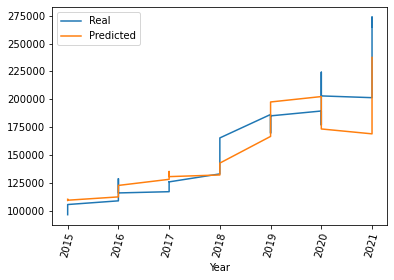

In [236]:
results.plot(rot = 75)

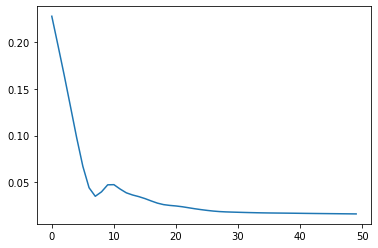

In [237]:
plt.plot(model_history.history["loss"])